In [237]:
%reset -f
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from tabulate import tabulate
import mestim as M              # routines for M-estimation given general sample objective functions
from matplotlib import pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
import seaborn as sns

df = pd.read_csv('dataset.csv')
Nobs=df['ID'].count()
df['const']=np.ones((Nobs,1))
df.head(20)
df.rename(columns={'Fast charge (min)':'ChargeTime'},inplace=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Graphs

<Axes: >

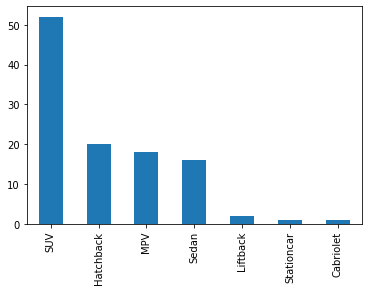

In [238]:
(df['Type'].value_counts() / 11).plot(kind='bar')

<Axes: >

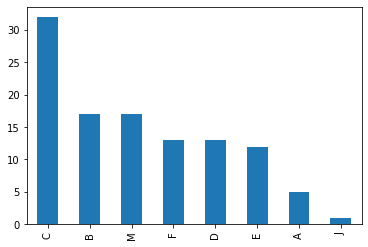

In [239]:
(df['Segment'].value_counts() / 11).plot(kind='bar')

<Axes: >

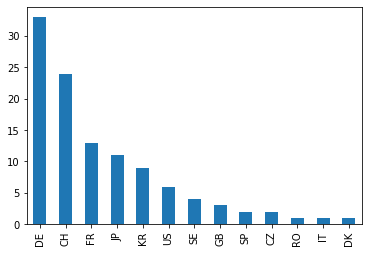

In [240]:
(df['Country'].value_counts() / 11).plot(kind='bar')

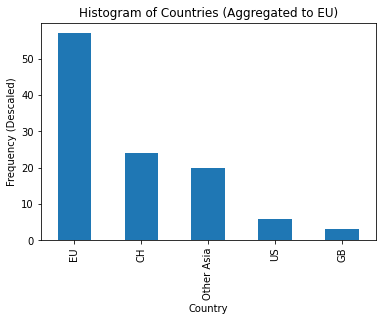

In [241]:
# Define a custom aggregation function
def aggregate_countries(country):
    if country in ['DE', 'FR', 'DK', 'IT', 'RO', 'CZ', 'SP', 'SE']:
        return 'EU'
    elif country in ['JP', 'KR']:
        return 'Other Asia'
    else:
        return country

# Plot the histogram with aggregated countries
(df['Country'].apply(aggregate_countries).value_counts() / 11).plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Frequency (Descaled)')
plt.title('Histogram of Countries (Aggregated to EU)')
plt.show()

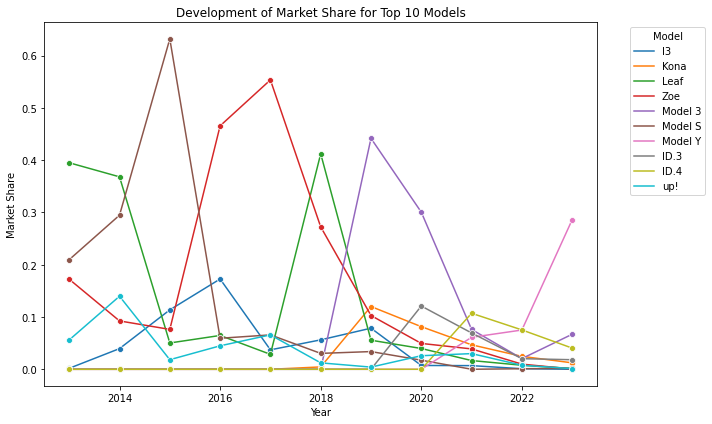

In [242]:
# Calculate the total market share for each model
model_market_share = df.groupby('Model')['Market share'].sum()

# Choose the top 10 models by market share
top_10_models = model_market_share.nlargest(10).index

# Filter the DataFrame to include only the top 10 models
df_top_n = df[df['Model'].isin(top_10_models)]

# Plot the development of market share for the top 10 models
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_top_n, x='year', y='Market share', hue='Model', marker='o')
plt.xlabel('Year')
plt.ylabel('Market Share')
plt.title('Development of Market Share for Top {} Models'.format(10))
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Creating dummies

In [243]:
# Creating dummies for each segment
df = pd.get_dummies(df, columns=['Segment'], drop_first=True)

# Creating log market share and transforming 0 prices

In [244]:
# Make a log market share column
df['log_market_share'] = df['Market share']
# Market share with 0 have to be change to 1 so we can take the log since log(1) = 0
df['log_market_share'] = df['log_market_share'].replace(0, 1)
# Take the log of the market share
df['log_market_share'] = np.log(df['log_market_share'])

# Prices with 0 have to be changed to -100 so we get -infitnity when taking the exponential since exp(0) = 1
df['Price'] = df['Price'].replace(0, -100)

# Independent OLS

In [245]:
y = df['Market share']
z = df[['const', 'Range', 'Price', 'HP', 'ChargeTime']]
dummies = df[['Segment_B', 'Segment_C', 'Segment_D', 'Segment_E', 'Segment_F', 'Segment_M', 'Segment_J']]
X = pd.concat([z, dummies], axis=1)

In [246]:
OLS_model = sm.OLS(y, X)
OLS_result = OLS_model.fit()
# Print summary of the regression results
print(OLS_result.summary())

                            OLS Regression Results                            
Dep. Variable:           Market share   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     6.280
Date:                Wed, 28 Feb 2024   Prob (F-statistic):           3.77e-10
Time:                        22:01:22   Log-Likelihood:                 2130.8
No. Observations:                1210   AIC:                            -4238.
Df Residuals:                    1198   BIC:                            -4176.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0121      0.009     -1.347      0.1

In [247]:
OLS_result.predict()

array([0.00637944, 0.00637944, 0.00637944, ..., 0.002307  , 0.002307  ,
       0.0148424 ])

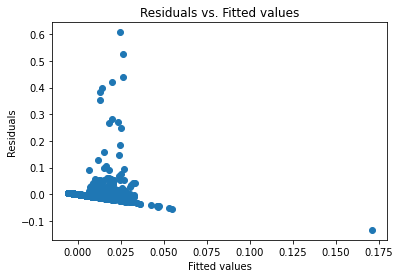

In [248]:
# Plot scatter plot of the residuals
plt.scatter(OLS_result.predict(), OLS_result.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted values')
plt.show()


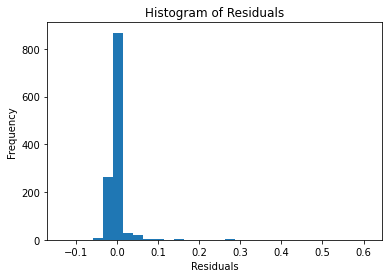

In [249]:
# Plot distribution of the residuals
plt.hist(OLS_result.resid, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# Logit

In [254]:
logit_model = sm.Logit(y, X)
logit_result = logit_model.fit()
# Print summary of the regression results
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.013482
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:           Market share   No. Observations:                 1210
Model:                          Logit   Df Residuals:                     1198
Method:                           MLE   Df Model:                           11
Date:                Wed, 28 Feb 2024   Pseudo R-squ.:                  -2.153
Time:                        22:03:11   Log-Likelihood:                -16.313
converged:                       True   LL-Null:                       -5.1738
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.6817      2.269     -2.945      0.003     -11.129      -2.235
Range          0.0029      0